# Chesser

### Initial Setup

In [1]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
#import seaborn as sns
from pathlib import Path

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

# Reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Check Tensorflow identifies GPU and enable memory growth
#physical_devices = tf.config.experimental.list_physical_Devices('GPU')
#print("Num GPUs available: " , len(physical_devices))
#tf.config.experimental.set_memory_grows(physical_devices[0], True)


In [2]:
data_dir = Path('input/classes')
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1002


In [3]:
batch_size = 64

# Train Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  seed=123,
  subset="training",
  label_mode='categorical',
  #image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  seed=123,
  subset="validation",
  label_mode='categorical',
  #image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(num_classes, class_names)

Found 994 files belonging to 13 classes.
Using 796 files for training.
Found 994 files belonging to 13 classes.
Using 198 files for validation.
13 ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']


### Standardize the data

In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.12476595 0.8694392


### Configure the dataset for performance

In [5]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#def configure_for_performance(ds):
#  ds = ds.cache()
#  ds = ds.shuffle(buffer_size=1000)
#  ds = ds.batch(batch_size)
#  ds = ds.prefetch(buffer_size=AUTOTUNE)
#  return ds

#train_ds = configure_for_performance(train_ds)
#val_ds = configure_for_performance(val_ds)

### Train model

In [6]:
import os
import numpy as np

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from keras.constraints import max_norm

# architecture of the neural network
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),
                activation='relu',
                kernel_constraint=max_norm(3.)))
model.add(MaxPooling2D(pool_size=(2,2)))
#Conv block 2
model.add(Conv2D(64, kernel_size=(5,5), activation='relu', kernel_constraint=max_norm(3.)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Identification
model.add(Flatten())
model.add(Dense(128, activation='relu', name='features'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='softmax'))
model.add(Dense(32, activation='softplus'))
model.add(Dense(64, activation='relu'))
model.add(Dense(13, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])
# the loss is minimized by the neural net
# optimizer is the method for training (Adam= stochastic gradient descent, adaptive estimation of first-order and second-order moments)
# metrics accuracy divides total by count, the number of correctly identified images to total number of images

LOGDIR = "./logs"
my_tensorboard = TensorBoard(log_dir = LOGDIR,
                            histogram_freq=1,
                            write_graph=True,
                            write_images=True)
# Hyperparamter
my_epochs = 2

history = model.fit(train_ds,
                   batch_size=batch_size,
                   callbacks=[my_tensorboard],
                   epochs=my_epochs,
                   verbose=1,
                   validation_data=val_ds)

#model.summary()

Epoch 1/2
13/13 [==============================] - 24s 1s/step - loss: 0.6712 - accuracy: 0.0603 - val_loss: 0.5601 - val_accuracy: 0.1010
Epoch 2/2
13/13 [==============================] - 19s 1s/step - loss: 0.4960 - accuracy: 0.0704 - val_loss: 0.4205 - val_accuracy: 0.1010


### Confusion Matrix and Learning Curve

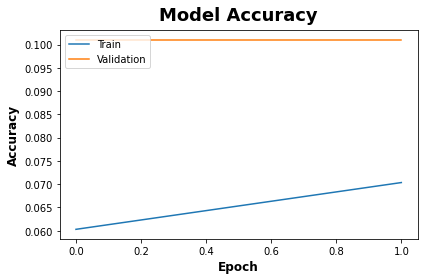

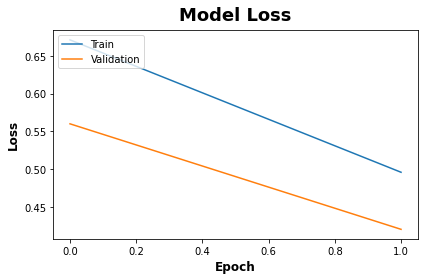

In [7]:
import matplotlib.pyplot as plt

# Training & Validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Training & Validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
#predictions = np.array([])
#labels =  np.array([])
#for x, y in test_ds:
#  predictions = np.concatenate([predictions, **np.argmax**(model.predict(x), axis = -1)])
#  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
# 
# Printing the input tensor
#print('labels: ',labels)
#print('Predictions: ',predictions)
 
# Evaluating confusion matrix
#mat = tf.math.confusion_matrix(labels,predictions)
 
#from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(mat=mat, class_names=class_names)


SyntaxError: invalid syntax (<ipython-input-25-cc99e4744c9d>, line 4)

In [ ]:
model.save('network.h5')

In [ ]:
#from tensorflow.keras.models import load_model
#new_model = load_model('network.h5')
#plttitle = "Training image nr {} \n class {}".format()
#plt.figure(figsize=(10, 10))
#class_names = train_ds.class_names
#for images, labels in train_ds.take(1):
#    for i in range(32):
#        ax = plt.subplot(6, 6, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        print(class_names)
#        #plt.title(class_names[labels[i]])
#        plt.axis("off")

#plt.figure(figsize=(10, 10))
#for images, labels in train_ds.take(1):
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    #plt.title(class_names[labels[i]])
#    print(labels[i])
#    plt.axis("off")